### Description
This is skeleton code for **Exercise 1: classification** for *L335 Machine Visual Perception*. For this task, we will formulate a classification network to predict the labels of images obtained from the FashionMNIST dataset and explore several key concepts in the design and training of the network.

You can run the rest of this file without any changes as a sanity check.

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import dill

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
if device == 'cuda':
    print(torch.cuda.get_device_name())

Using cuda device
Tesla P100-PCIE-16GB


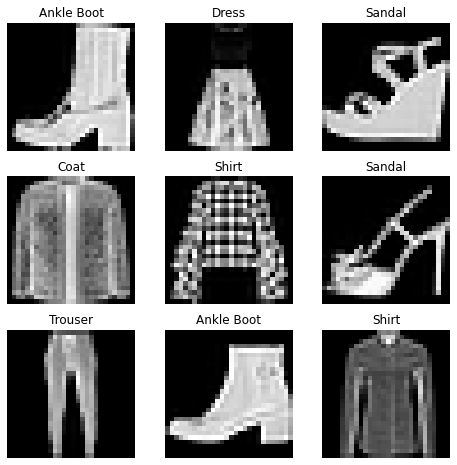

In [4]:
# download the training and testing dataset
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_batch_size = 64
test_batch_size = 10

# initialise the data loader
trainloader = DataLoader(training_data, batch_size=train_batch_size, shuffle=True, num_workers=2)

testloader = DataLoader(test_data, batch_size=test_batch_size, shuffle=True, num_workers=2)

# establish the labels map
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# preview the dataset
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [5]:
# initialise a 3-layer fully-connected network
class BasicNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.n_hidden = 512
        self.linear1 = nn.Linear(28*28, self.n_hidden)
        self.linear2 = nn.Linear(self.n_hidden, self.n_hidden)
        self.linear3 = nn.Linear(self.n_hidden, 10)
        self.act_ReLU = nn.ReLU()

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.linear1(x)
        x = self.act_ReLU(x)
        x = self.linear2(x)
        x = self.act_ReLU(x)
        x = self.linear3(x)
        return x

In [6]:
basic_model = BasicNet().to(device)
print(basic_model)

# define the loss and optimiser
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(basic_model.parameters(), lr=0.001, momentum=0.9)

BasicNet(
  (linear1): Linear(in_features=784, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=10, bias=True)
  (act_ReLU): ReLU()
)


In [7]:
# helper function to compute the model accuracy on the specified dataset
def compute_accuracy(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    return correct, test_loss

In [8]:
# training
def train(model, optimizer, loss_fn, n_epochs=10, trainloader=trainloader):
    start = time.time()

    train_accuracy, train_loss = compute_accuracy(trainloader, model, loss_fn)
    test_accuracy, test_loss = compute_accuracy(testloader, model, loss_fn)
    
    history = {
        'accuracy': {
            'train': [train_accuracy],
            'test': [test_accuracy]
        },
        'loss': {
            'train': [train_loss],
            'test': [test_loss]
        }
    }
    for epoch in range(n_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
    
            # zero the gradients of the training parameters
            optimizer.zero_grad()
    
            # forward feed
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
    
            # backpropagate
            loss.backward()
    
            # update the training parameters
            optimizer.step()
    
            # print statistics
            running_loss += loss.item()
            if i % 200 == 199:    # print every 200 mini-batches
                print('epoch:', epoch + 1, 'batch:', i, 'loss:', running_loss / 200)
                running_loss = 0.0
    
        train_accuracy, train_loss = compute_accuracy(trainloader, model, loss_fn)
        test_accuracy, test_loss = compute_accuracy(testloader, model, loss_fn)
    
        print('accuracy on training set:', train_accuracy)
        print('accuracy on test set:', test_accuracy)
        
        history['accuracy']['train'].append(train_accuracy)
        history['accuracy']['test'].append(test_accuracy)
        history['loss']['train'].append(train_loss)
        history['loss']['test'].append(test_loss)        
    
    elapsed_time = datetime.timedelta(seconds=time.time()-start)
    print('Finished Training')
    print(f'Elapsed time: {elapsed_time} ({elapsed_time/n_epochs} per epoch)')
    
    return history

In [9]:
train_epochs = 20

In [7]:
basic_history = train(basic_model, optimizer, loss_fn, n_epochs=train_epochs)

epoch: 1 batch: 199 loss: 2.1391631531715394
epoch: 1 batch: 399 loss: 1.5254528552293778
epoch: 1 batch: 599 loss: 1.0752620255947114
epoch: 1 batch: 799 loss: 0.8814401099085808
accuracy on training set: 0.72405
accuracy on test set: 0.7137
epoch: 2 batch: 199 loss: 0.751473394036293
epoch: 2 batch: 399 loss: 0.7052342519164085
epoch: 2 batch: 599 loss: 0.6721869391202927
epoch: 2 batch: 799 loss: 0.6469738231599331
accuracy on training set: 0.7937166666666666
accuracy on test set: 0.7813
epoch: 3 batch: 199 loss: 0.6006628453731537
epoch: 3 batch: 399 loss: 0.5804312546551228
epoch: 3 batch: 599 loss: 0.5651793804764748
epoch: 3 batch: 799 loss: 0.5568422716856003
accuracy on training set: 0.8178333333333333
accuracy on test set: 0.8037
epoch: 4 batch: 199 loss: 0.5185689654946327
epoch: 4 batch: 399 loss: 0.5201960378885269
epoch: 4 batch: 599 loss: 0.5159001341462135
epoch: 4 batch: 799 loss: 0.5225139570236206
accuracy on training set: 0.8282
accuracy on test set: 0.8136
epoch: 5

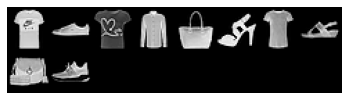

GroundTruth:  T-Shirt Sneaker T-Shirt Shirt Bag   Sandal T-Shirt Sandal Bag   Sneaker
Predicted:  T-Shirt Sneaker T-Shirt Shirt Bag   Sandal T-Shirt Sandal Bag   Sneaker


In [8]:
# visualise the performance on the test data
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

def imshow(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{labels_map[int(labels[j])]:5s}' for j in range(test_batch_size)))

outputs = basic_model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{labels_map[int(predicted[j])]:5s}' for j in range(test_batch_size)))

### Task 1

The current forward model is a basic three-layer fully connected network (FCN). As introduced in the lecture, there are many possibilities, such as a CNN, to tailor the network architecture to better distil the local features of images. The first task is to update the network architecture to a CNN with three convolutional layers and two FC layers. Choose the hyperparameters of the CNN (e.g. the number of output channels, kernel size, hidden layer size, etc. of the convolutional layers, pooling layer, and the FC layers) such that the total number of training parameters is similar to that of the basic net. Retrain the network with the same epoch and batch size and compare the training and test accuracy of the CNN with the basic net.

**Deliverable:** Report the choice of the hyperparameters of your CNN and show the calculation of the number of training parameters. Show a quantitative comparison of the model accuracy of the basic net and the CNN on the training and test data with a plot of accuracy vs. epochs. Report whether the model is under-fitted, well-fitted, or over-fitted, explain the possible causes, and suggest potential solutions. Visualise the feature maps of each convolutional layer.

In [10]:
# initialise a 3-layer fully-connected network
class ConvNet(nn.Module):
    def __init__(self, n_hidden, conv_channels, kernel_size):
        super().__init__()
        self.n_hidden = n_hidden
        self.conv_channels = conv_channels
        
        self.conv1 = nn.Conv2d(1, self.conv_channels, kernel_size, padding='same')
        self.conv2 = nn.Conv2d(self.conv_channels, self.conv_channels, kernel_size, padding='same')
        self.conv3 = nn.Conv2d(self.conv_channels, self.conv_channels, kernel_size, padding='same')
        
        self.linear1 = nn.Linear(self.conv_channels*16*16, self.n_hidden)
        self.linear2 = nn.Linear(self.n_hidden, self.n_hidden)
        self.linear3 = nn.Linear(self.n_hidden, 10)
        
        self.pool = nn.MaxPool2d(kernel_size, stride=1)
        self.ReLU = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.ReLU(self.pool(x))
        
        x = self.conv2(x)
        x = self.ReLU(self.pool(x))
        
        x = self.conv3(x)
        x = self.ReLU(self.pool(x))
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
                
        x = self.ReLU(self.linear1(x))
        x = self.ReLU(self.linear2(x))
        x = self.ReLU(self.linear3(x))
        return x

In [11]:
conv_model = ConvNet(n_hidden=256, conv_channels=9, kernel_size=5).to(device)
print(conv_model)

# define the loss and optimiser
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(conv_model.parameters(), lr=0.001, momentum=0.9)

ConvNet(
  (conv1): Conv2d(1, 9, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv2): Conv2d(9, 9, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv3): Conv2d(9, 9, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (linear1): Linear(in_features=2304, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=5, stride=1, padding=0, dilation=1, ceil_mode=False)
  (ReLU): ReLU()
)


In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Basic network training parameters: {count_parameters(basic_model):,}')
print(f'Convolutional network training parameters: {count_parameters(conv_model):,}')

Basic network training parameters: 669,706
Convolutional network training parameters: 662,744


In [119]:
conv_history = train(conv_model, optimizer, loss_fn, n_epochs=train_epochs)

epoch: 1 batch: 199 loss: 2.3010993802547457
epoch: 1 batch: 399 loss: 2.294318697452545
epoch: 1 batch: 599 loss: 2.176096054315567
epoch: 1 batch: 799 loss: 1.489182625412941
accuracy on training set: 0.6424
accuracy on test set: 0.6357
epoch: 2 batch: 199 loss: 0.8326843893527984
epoch: 2 batch: 399 loss: 0.766555684953928
epoch: 2 batch: 599 loss: 0.6919533501565457
epoch: 2 batch: 799 loss: 0.6473279233276844
accuracy on training set: 0.7768666666666667
accuracy on test set: 0.7702
epoch: 3 batch: 199 loss: 0.6066831786930561
epoch: 3 batch: 399 loss: 0.5775668193399907
epoch: 3 batch: 599 loss: 0.5544421854615211
epoch: 3 batch: 799 loss: 0.5406636704504489
accuracy on training set: 0.8119
accuracy on test set: 0.8014
epoch: 4 batch: 199 loss: 0.5125208932161331
epoch: 4 batch: 399 loss: 0.49585449278354643
epoch: 4 batch: 599 loss: 0.4978248847275972
epoch: 4 batch: 799 loss: 0.46535862013697626
accuracy on training set: 0.8197333333333333
accuracy on test set: 0.8115
epoch: 5 b

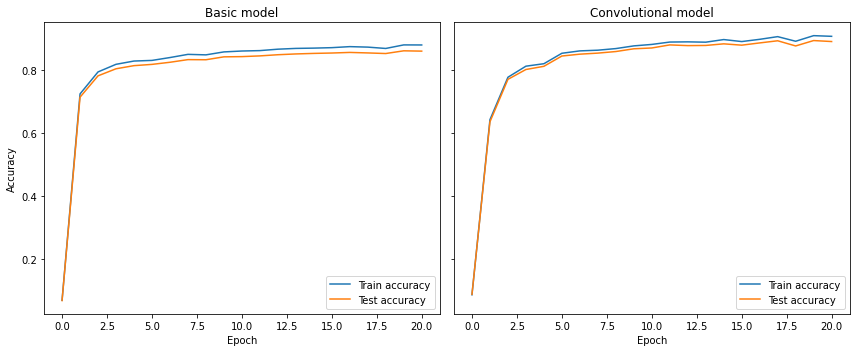

In [120]:
_, axs = plt.subplots(1,2, figsize=(12,5), sharey=True)

axs[0].set_title('Basic model')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].plot(basic_history['accuracy']['train'], label='Train accuracy')
axs[0].plot(basic_history['accuracy']['test'], label='Test accuracy')
axs[0].legend(loc='lower right')

axs[1].set_title('Convolutional model')
axs[1].set_xlabel('Epoch')
axs[1].plot(conv_history['accuracy']['train'], label='Train accuracy')
axs[1].plot(conv_history['accuracy']['test'], label='Test accuracy')
axs[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

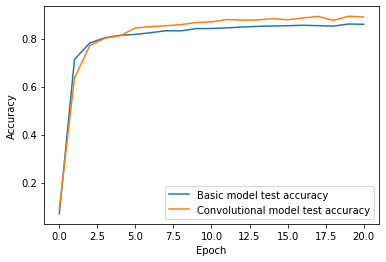

In [121]:
plt.plot(basic_history['accuracy']['test'], label='Basic model test accuracy')
plt.plot(conv_history['accuracy']['test'], label='Convolutional model test accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.show()

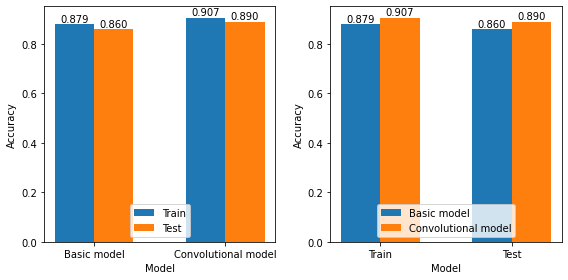

In [128]:
x = np.arange(2)
width = 0.3

_, axs = plt.subplots(1, 2, figsize=(8,4))

train_bars = axs[0].bar(x-width/2, [basic_history['accuracy']['train'][-1], conv_history['accuracy']['train'][-1]], width, color='tab:blue', label='Train')
test_bars = axs[0].bar(x+width/2, [basic_history['accuracy']['test'][-1], conv_history['accuracy']['test'][-1]], width, color='tab:orange', label='Test')

axs[0].bar_label(train_bars, fmt='{:.3f}')
axs[0].bar_label(test_bars, fmt='{:.3f}')

axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Model')
axs[0].set_xticks(x, ['Basic model', 'Convolutional model'])
axs[0].legend(loc='lower center')

basic_bars = axs[1].bar(x-width/2, [basic_history['accuracy']['train'][-1], basic_history['accuracy']['test'][-1]], width, color='tab:blue', label='Basic model')
conv_bars = axs[1].bar(x+width/2, [conv_history['accuracy']['train'][-1], conv_history['accuracy']['test'][-1]], width, color='tab:orange', label='Convolutional model')

axs[1].bar_label(basic_bars, fmt='{:.3f}')
axs[1].bar_label(conv_bars, fmt='{:.3f}')

axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Model')
axs[1].set_xticks(x, ['Train', 'Test'])
axs[1].legend(loc='lower center')

plt.tight_layout()
plt.show()

For my CNN, I kept the parameters the same for all of the convolutional layers.  For my CNN, I kept the parameters the same for all of the convolutional layers. For all convolutional layers I introduced padding and for the pooling layers I used a stride of 1, as I found this produced the best results consistently and prevented the dimensionality from rapidly decreasing (since 28x28 isn't very large). For the convolutional portion of the network, I used a kernel size of 5 and produced 9 output-channels, while for the linear portion of the model I used a hidden size of 128. The basic model had 669,706 training parameters while the convolutional model has 662,744 (see my `count_parameters` function above for how these were computed).

Overall the difference in performance between the basic model and the convolutional model is relatively small, but it is still notable (about 3% improvement on both train and test sets). Additionally, the convolutional model began outperforming the basic model in only about 5 epochs. Both models are slightly overfitted, having an approximate 2% reduction in performance for the test set compared to the training set. However, this different is rather small, suggesting a reasonably good fit. This overfitting may potentially be resolved using smarter techniques, such as edge detection.

### Task 2
In addition to the network design, training parameters and algorithms also influence the performance of the network. The second task is to retrain your CNN constructed in task 1 with a different learning rate and batch size.

**Deliverable:** Show a quantitative comparison of the model accuracy on the training and test data with a plot of accuracy vs. epochs with a learning rate of 0.1, 0.001, and 0.00001. Summarise the difference in performance and explain the cause. Fixing the learning rate to be 0.001, show a quantitative comparison of the model accuracy on the training and test data with a plot of accuracy vs. epochs with a batch size of 4, 64, and 512. Summarise the difference in performance and explain the cause.

In [140]:
loss_fn = nn.CrossEntropyLoss()

lrs = {
    .1: None, 
    .001: None,
    .00001: None
}

for lr in lrs.keys():
    try:
        lrs[lr] = dill.load(open(f'lr_{lr}.pkl', 'rb'))
        print(f'Loaded lr={lr} data from file.')
    except:
        print(f'lr={lr} data not found. Training model...')
        lr_conv_model = ConvNet(n_hidden=256, conv_channels=9, kernel_size=5).to(device)
        optimizer = torch.optim.SGD(lr_conv_model.parameters(), lr=lr, momentum=0.9)
        
        lrs[lr] = train(lr_conv_model, optimizer, loss_fn, n_epochs=train_epochs)
        dill.dump(lrs[lr], open(f'lr_{lr}.pkl', 'wb'))

epoch: 1 batch: 199 loss: 2.2966218972206116
epoch: 1 batch: 399 loss: 2.3025848865509033
epoch: 1 batch: 599 loss: 2.3025848865509033
epoch: 1 batch: 799 loss: 2.3025848865509033
accuracy on training set: 0.1
accuracy on test set: 0.1
epoch: 2 batch: 199 loss: 2.3025848865509033
epoch: 2 batch: 399 loss: 2.3025848865509033
epoch: 2 batch: 599 loss: 2.3025848865509033
epoch: 2 batch: 799 loss: 2.3025848865509033
accuracy on training set: 0.1
accuracy on test set: 0.1
epoch: 3 batch: 199 loss: 2.3025848865509033
epoch: 3 batch: 399 loss: 2.3025848865509033
epoch: 3 batch: 599 loss: 2.3025848865509033
epoch: 3 batch: 799 loss: 2.3025848865509033
accuracy on training set: 0.1
accuracy on test set: 0.1
epoch: 4 batch: 199 loss: 2.3025848865509033
epoch: 4 batch: 399 loss: 2.3025848865509033
epoch: 4 batch: 599 loss: 2.3025848865509033
epoch: 4 batch: 799 loss: 2.3025848865509033
accuracy on training set: 0.1
accuracy on test set: 0.1
epoch: 5 batch: 199 loss: 2.3025848865509033
epoch: 5 ba

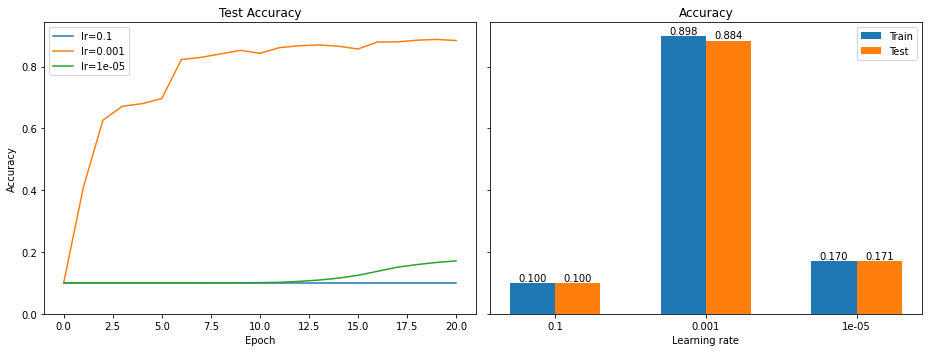

In [163]:
_, axs = plt.subplots(1,2, figsize=(13,5), sharey=True)

for lr in lrs.keys():
    axs[0].plot(lrs[lr]['accuracy']['test'], label=f'lr={lr}')
axs[0].set_title('Test Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend()

width = 0.3
x = np.arange(len(lrs))

lr_train_bars = axs[1].bar(x-width/2, [lrs[lr]['accuracy']['train'][-1] for lr in lrs.keys()], width, label=f'Train')
lr_test_bars = axs[1].bar(x+width/2, [lrs[lr]['accuracy']['test'][-1] for lr in lrs.keys()], width, label=f'Test')
axs[1].bar_label(lr_train_bars, fmt='{:.3f}')
axs[1].bar_label(lr_test_bars, fmt='{:.3f}')
axs[1].set_title('Accuracy')
axs[1].set_xticks(np.arange(len(lrs)), lrs.keys())
axs[1].set_xlabel('Learning rate')
axs[1].legend()

plt.tight_layout()
plt.show()

In [22]:
loss_fn = nn.CrossEntropyLoss()

batch_sizes = {
    512: None,
    64: None,
    4: None
}

for batch_size in batch_sizes.keys():
    try:
        batch_sizes[batch_size] = dill.load(open(f'bs_{bs}.pkl', 'rb'))
        print(f'Loaded batch_size={bs} data from file.')
    except:
        print(f'batch_size={bs} data not found. Training model...')
        bs_trainloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=2)
        
        bs_conv_model = ConvNet(n_hidden=256, conv_channels=9, kernel_size=5).to(device)
        optimizer = torch.optim.SGD(bs_conv_model.parameters(), lr=0.001, momentum=0.9)
    
        batch_sizes[batch_size] = train(bs_conv_model, optimizer, loss_fn, n_epochs=train_epochs, trainloader=bs_trainloader)
        dill.dump(batch_sizes[batch_size], open(f'bs_{batch_size}.pkl', 'wb'))

accuracy on training set: 0.1829
accuracy on test set: 0.1842
accuracy on training set: 0.23201666666666668
accuracy on test set: 0.233
accuracy on training set: 0.2679166666666667
accuracy on test set: 0.2672
accuracy on training set: 0.2894
accuracy on test set: 0.2892
accuracy on training set: 0.26471666666666666
accuracy on test set: 0.2643
accuracy on training set: 0.48473333333333335
accuracy on test set: 0.488
accuracy on training set: 0.5060166666666667
accuracy on test set: 0.506
accuracy on training set: 0.55105
accuracy on test set: 0.5523
accuracy on training set: 0.5701333333333334
accuracy on test set: 0.565
accuracy on training set: 0.57665
accuracy on test set: 0.5708
accuracy on training set: 0.5844166666666667
accuracy on test set: 0.5854
accuracy on training set: 0.6112166666666666
accuracy on test set: 0.6071
accuracy on training set: 0.6250333333333333
accuracy on test set: 0.6224
accuracy on training set: 0.6146
accuracy on test set: 0.6156
accuracy on training se

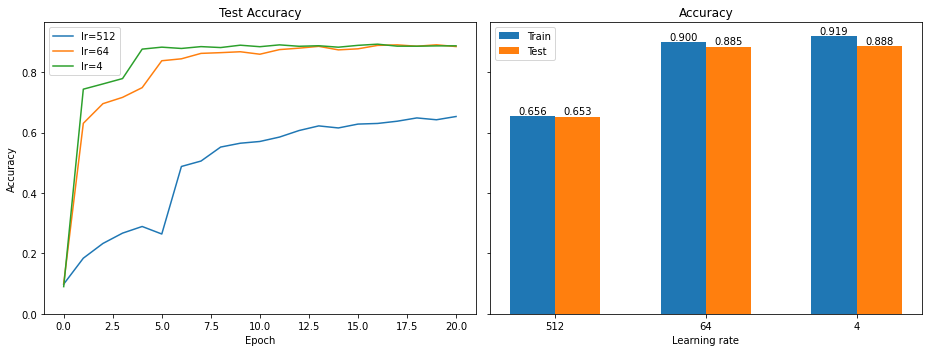

In [25]:
_, axs = plt.subplots(1,2, figsize=(13,5), sharey=True)

for bs in batch_sizes.keys():
    axs[0].plot(batch_sizes[bs]['accuracy']['test'], label=f'lr={bs}')
axs[0].set_title('Test Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend()

width = 0.3
x = np.arange(len(batch_sizes))

bs_train_bars = axs[1].bar(x-width/2, [batch_sizes[bs]['accuracy']['train'][-1] for bs in batch_sizes.keys()], width, label=f'Train')
bs_test_bars = axs[1].bar(x+width/2, [batch_sizes[bs]['accuracy']['test'][-1] for bs in batch_sizes.keys()], width, label=f'Test')
axs[1].bar_label(bs_train_bars, fmt='{:.3f}')
axs[1].bar_label(bs_test_bars, fmt='{:.3f}')
axs[1].set_title('Accuracy')
axs[1].set_xticks(np.arange(len(batch_sizes)), batch_sizes.keys())
axs[1].set_xlabel('Learning rate')
axs[1].legend()

plt.tight_layout()
plt.show()